# Reinforcement Learning Car Agent in Gymnasium 0.28 and Box2D 2.3.10

(From: NTUT DRL Homework 2: CarRacing)

CarRacing is the continuous control task learning from pixels, a top-down racing environment. State consists of 96x96 pixels. Reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles in track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points. CarRacing-v0 defines "solving" as getting average reward of 900 over 100 consecutive trials.
This example notebook refers to the github:

https://github.com/Rafael1s/Deep-Reinforcement-Learning-Udacity/tree/master/CarRacing-From-Pixels-PPO

In [ ]:
# Mount GDrive, change directory and check contents of folder.

import os
import tensorflow as tf
from google.colab import drive
from google.colab import files

PROJECT_FOLDER = "/content/gdrive/My Drive/Colab Notebooks/Risto"

drive.mount('/content/gdrive/')
os.chdir(PROJECT_FOLDER)
print("Current dir: ", os.getcwd())

!python3 --version

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Current dir:  /content/gdrive/My Drive/Colab Notebooks/Risto
Python 3.10.11


## Needed package Setup

In [ ]:
!pip install gymnasium==0.28.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We install the version 2.3.10 of Box2D by building it from source

In [ ]:
!sudo apt install swig && pip install "git+https://github.com/pybox2d/pybox2d.git@2.3.10#egg=Box2D"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (4.0.1-5build1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pybox2d/pybox2d.git (to revision 2.3.10) to /tmp/pip-install-cp0wv75f/box2d_083bc9ad571c41bdb4389e8cb466b759
  Running command git clone --filter=blob:none --quiet https://github.com/pybox2d/pybox2d.git /tmp/pip-install-cp0wv75f/box2d_083bc9ad571c41bdb4389e8cb466b759
  Running command git checkout -q ed9d7b04f7099a15984c727dbce46c13abd64409
  Resolved https://github.com/pybox2d/pybox2d.git to commit ed9d7b04f7099a15984c727dbce46c13abd64409
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install gymnasium[box2d]==0.28.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip list | grep -E "[bB]ox|gym" 

Box2D                         2.3.10
box2d-py                      2.3.5
gym                           0.25.2
gym-notices                   0.0.8
gymnasium                     0.28.1


# GPU Information

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 23 14:18:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Library imports

In [ ]:
import gymnasium as gym
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
gymlogger.set_level(40) #error only

#import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

# Hyperparameters

Create a new dictionary for a new experiment (e.g. CONFIG_5)

In [ ]:
from mllib import CFileStore
from mllib.experiment import CMLExperimentConfig

CONFIG = CMLExperimentConfig("Hyperparameters/RLExperiment8.json")

MODEL_NUMBER = CONFIG["ModelNumber"]
sModelFolder = "%s_%.2d" % (CONFIG["ModelName"], CONFIG["ModelNumber"])
oModelFileStore = CFileStore("MLModels").SubFS(sModelFolder)

## Hyperparameters
This code uses global variables. We assign the hyperparams to them.

In [ ]:
img_stack=CONFIG["Data.ImageStackCount"]
ACTION_REPEAT = CONFIG["Data.ActionRepeatCount"]
seed = CONFIG["RandomSeed"]

nImageWidth, nImageHeight = CONFIG["Data.EnvironmentResolution"]

transition = np.dtype([('s', np.float64, (img_stack, nImageWidth, nImageHeight)), 
                       ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (img_stack, nImageWidth, nImageHeight))])

NUM_EPISODES = CONFIG["Training.RL.NumEpisodes"] #300

# Duration of Episode ~20secs
#print("Estimated training time %d mins" % ((NUM_EPISODES*20.0)/0.0))
print("Estimated training time %d hours" % ((NUM_EPISODES*8.0)/2000.0))

Estimated training time 4 hours


## CNN Model
This example uses the **Torch** framework. The class `Net` inherits from `nn.Module` where in its constructor the layers objects are created, in the same manner done in `keras`. The `forward` method is the `call` method of `keras`

In [ ]:
# Import Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import time
from collections import deque

Old CNN 

In [ ]:
class Net(nn.Module):
    """
    Convolutional Neural Network for PPO
    """

    def __init__(self, p_oConfig):

        self.Config = p_oConfig
        self.img_stack = CONFIG["Data.ImageStackCount"]

        self.InputLayer1 = CONFIG["InputLayer1"]
        self.InputLayer2 = CONFIG["InputLayer2"]
        self.InputLayer3 = CONFIG["InputLayer3"]
        self.InputLayer4 = CONFIG["InputLayer4"]
        self.InputLayer5 = CONFIG["InputLayer5"]
        
        self.OutputLayer0 = CONFIG["OutputLayer0"]
        self.OutputLayer1 = CONFIG["OutputLayer1"]
        self.OutputLayer2 = CONFIG["OutputLayer2"]
        self.OutputLayer3 = CONFIG["OutputLayer3"]
        self.OutputLayer4 = CONFIG["OutputLayer4"]
        self.OutputLayer5 = CONFIG["OutputLayer5"]

        super(Net, self).__init__()
        self.cnn_base = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(self.img_stack, self.OutputLayer0, kernel_size=4, stride=2),
            nn.ReLU(),  # activation
            nn.Conv2d(self.InputLayer1, self.OutputLayer1, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),  # activation
            nn.Conv2d(self.InputLayer2, self.OutputLayer2, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),  # activation
            nn.Conv2d(self.InputLayer3, self.OutputLayer3, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),  # activation
            nn.Conv2d(self.InputLayer4, self.OutputLayer4, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),  # activation
            nn.Conv2d(self.InputLayer5, self.OutputLayer5, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),  # activation
        )  # output shape (256, 1, 1)
        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1

        return (alpha, beta), v

In [ ]:
class CNN_v1(nn.Module):
    def __init__(self, p_oConfig):

        self.Config = p_oConfig
        self.img_stack = CONFIG["Data.ImageStackCount"]

        self.InputLayer1 = CONFIG["InputLayer1"]
        self.InputLayer2 = CONFIG["InputLayer2"]
        
        self.OutputLayer0 = CONFIG["OutputLayer0"]
        self.OutputLayer1 = CONFIG["OutputLayer1"]
        self.OutputLayer2 = CONFIG["OutputLayer2"]

        super(CNN_v1, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(self.img_stack, self.OutputLayer0, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(self.InputLayer1, self.OutputLayer1, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(self.InputLayer2, self.OutputLayer2, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Linear(4096, 512)

        self.alpha_head = nn.Sequential(
            nn.Linear(512, 3), 
            nn.Softplus()
        )
        
        self.beta_head = nn.Sequential(
            nn.Linear(512, 3), 
            nn.Softplus()
        )

        self.v = nn.Sequential(
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc(x))

        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1
        v = self.v(x)

        return (alpha, beta), v

## Reinforcement Learning Agent

This is the class that implements RL. You can notice the value function
as `target_v = r + GAMMA * self.net(next_s)` where GAMMA is the discount factor hyperparameter

In [ ]:
from mmap import MADV_DOFORK
class Agent():
    """ Agent for training """
    
    def __init__(self, device, p_oConfig):

        self.Config = p_oConfig
        
        self.max_size = CONFIG["Training.RL.MaxSize"]
        self.training_step = 0
        self.net = CNN_v1(CONFIG).double().to(device)
        self.buffer = np.empty(self.max_size, dtype=transition)
        self.counter = 0
        self.device = device
        self.gamma = CONFIG["Training.RL.Gamma"]  
        self.epoch = CONFIG["Training.RL.Epochs"] 
        self.batch = CONFIG["Training.RL.BatchSize"]
        self.eps = CONFIG["Training.RL.EPS"]
        self.learning_rate = CONFIG["Training.RL.LearningRate"]
                 
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate)  ## lr=1e-3

    def select_action(self, state):
        state = torch.from_numpy(state).double().to(self.device).unsqueeze(0)
        
        with torch.no_grad():
            alpha, beta = self.net(state)[0]
        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp


    def store(self, transition):
        self.buffer[self.counter] = transition
        self.counter += 1
        if self.counter == self.max_size:
            self.counter = 0
            return True
        else:
            return False

    def update(self):
        self.training_step += 1

        s = torch.tensor(self.buffer['s'], dtype=torch.double).to(self.device)
        a = torch.tensor(self.buffer['a'], dtype=torch.double).to(self.device)
        r = torch.tensor(self.buffer['r'], dtype=torch.double).to(self.device).view(-1, 1)
        next_s = torch.tensor(self.buffer['s_'], dtype=torch.double).to(self.device)

        old_a_logp = torch.tensor(self.buffer['a_logp'], dtype=torch.double).to(self.device).view(-1, 1)

        with torch.no_grad():
            target_v = r + self.gamma * self.net(next_s)[1]
            adv = target_v - self.net(s)[1]
            # adv = (adv - adv.mean()) / (adv.std() + 1e-8)

        for nEpochNumber in range(self.epoch):
            print("Agent updating. Epoch %d" % (nEpochNumber + 1))
            for index in BatchSampler(SubsetRandomSampler(range(self.max_size)), self.batch, False):

                alpha, beta = self.net(s[index])[0]
                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
                ratio = torch.exp(a_logp - old_a_logp[index])

                surr1 = ratio * adv[index]
                
                # clipped function
                surr2 = torch.clamp(ratio, 1.0 - self.eps, 1.0 + self.eps) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.smooth_l1_loss(self.net(s[index])[1], target_v[index])
                loss = action_loss + 2. * value_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

### Initializing Training Environment

In [ ]:
# Initializing Training Environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)


torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)



env = gym.make('CarRacing-v2', verbose=0, render_mode='rgb_array')
state = env.reset()
print('env.action_space.shape: ', env.action_space.shape)
reward_threshold = env.spec.reward_threshold
print('reward_threshold', reward_threshold)

device:  cuda
env.action_space.shape:  (3,)
reward_threshold 900


### Preprocessing CarRacing Screenshots

frame.shape:  (96, 96, 3)
img.shape:  (96, 96)


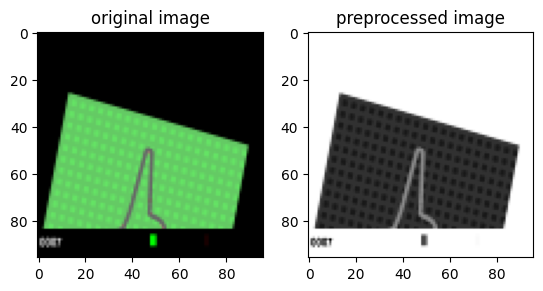

In [ ]:
# show what a preprocessed image looks like
frame, reward, terminated, truncated, info = env.step(np.array([2., 1., 1.]))

print('frame.shape: ', frame.shape)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

#-------------------------------#

def rgb2gray(rgb, norm=True):
        # rgb image -> gray [0, 1]
    gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
    if norm:
        # normalize
        gray = gray / 128. - 1.
    return gray

img_gray = rgb2gray(frame)

#-------------------------------# 
plt.subplot(1,2,2)
plt.title('preprocessed image')

print('img.shape: ', img_gray.shape)

# 96 x 96 black and white image
plt.imshow(img_gray, cmap='Greys')
plt.show()

### Define Wrapper for Our Environment
The environment wrapper emulates each step of the episode with `env.step`

In [ ]:
class Wrapper():
    """
    Environment wrapper for CarRacing 
    """

    def __init__(self, p_oConfig, env, p_bIsRendering=False):

        self.Config = p_oConfig
        self.env = env  
        self.IsRendering = p_bIsRendering
        self.action_repeat = CONFIG["Data.ActionRepeatCount"]

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb, _ = self.env.reset()
        img_gray = rgb2gray(img_rgb)
        self.stack = [img_gray] * img_stack  # four frames for decision
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(self.action_repeat):
            if self.IsRendering:
                self.env.render()
            img_rgb, reward, die, truncated, info = self.env.step(action)
            # don't penalize "die state"
            if die:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward
            # if no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img_gray = rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == img_stack
        return np.array(self.stack), total_reward, done, die


    @staticmethod
    def reward_memory():
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

## Training Process
There is the `ppo_train` that runs the agent training process and the `save` that saves the trained state of the agent to be reloaded.

In [ ]:
def ppo_train(n_episodes=500, save_every=100):
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    timestep_after_last_save = 0
    
    time_start = time.time()

    running_score = 0
    state = env_wrap.reset()
    
    i_lim = 0
    
    for i_episode in range(n_episodes):
        
        timestep = 0
        total_reward = 0
        
        ## score = 0
        state = env_wrap.reset()

        while True:    
            
            action, a_logp = agent.select_action(state)
            next_state, reward, done, die  = env_wrapstep( 
                action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            if agent.store((state, action, a_logp, reward, next_state)):
                print('updating')
                agent.update()
            
            total_reward += reward
            state = next_state
            
            timestep += 1  
            timestep_after_last_save += 1
            
            if done or die:
                break
                
        running_score = running_score * 0.99 + total_reward * 0.01

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        s = (int)(time.time() - time_start)        
        print('Ep. {}, Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Run.Score {:.2f}, \
Time: {:02}:{:02}:{:02} '\
            .format(i_episode, timestep, \
                    total_reward, avg_score, running_score, s//3600, s%3600//60, s%60))  
       
        
        # Save episode is equal to "save_every" timesteps
        if i_episode+1 % save_every == 0:

            suf = str(i_episode)
            save(agent, '', 'model_weights', suf)
            
        if np.mean(scores_deque) > reward_threshold:
            print("Solved environment! Running score is {:.2f}, Avg.Score: {:.2f} !" \
                  .format(running_score, avg_score))
            break
            
    return scores_array, avg_scores_array    
            


In [ ]:
def ppo_train(n_episodes=500, save_every=100):
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    timestep_after_last_save = 0
    
    time_start = time.time()

    running_score = 0
    state = env_wrap.reset()
    
    i_lim = 0
    
    for i_episode in range(n_episodes):
        
        timestep = 0
        total_reward = 0
        
        ## score = 0
        state = env_wrap.reset()

        while True:    
            
            action, a_logp = agent.select_action(state)
            next_state, reward, done, die  = env_wrap.step( 
                action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            if agent.store((state, action, a_logp, reward, next_state)):
                print('updating')
                agent.update()
            
            total_reward += reward
            state = next_state
            
            timestep += 1  
            timestep_after_last_save += 1
            
            if done or die:
                break
                
        running_score = running_score * 0.99 + total_reward * 0.01

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        s = (int)(time.time() - time_start)        
        print('Ep. {}, Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Run.Score {:.2f}, \
Time: {:02}:{:02}:{:02} '\
            .format(i_episode, timestep, \
                    total_reward, avg_score, running_score, s//3600, s%3600//60, s%60))  
       
        
        # Save episode is equal to "save_every" timesteps
        if i_episode+1 % save_every == 0:

            suf = str(i_episode)
            save(agent, '', 'model_weights', suf)
            
        if np.mean(scores_deque) > reward_threshold:
            print("Solved environment! Running score is {:.2f}, Avg.Score: {:.2f} !" \
                  .format(running_score, avg_score))
            break
            
    return scores_array, avg_scores_array    
            


### Training 
We should have a high number of NUM_EPISODES for a successful training.
Here is just 3 for preview of the process


In [ ]:
def save(agent, filename):
    torch.save(agent.net.state_dict(), filename)


def load(agent, filename):
    agent.net.load_state_dict(torch.load(filename))  

In [ ]:

IS_RETRAINING = False

agent = Agent(device, CONFIG)
env_wrap = Wrapper(CONFIG,env)



sModelStateFileName = "model%d_weights.pth" % MODEL_NUMBER


bMustTrain = (not os.path.exists(oModelFileStore.File(sModelStateFileName))) or IS_RETRAINING


if bMustTrain:
  print("[>] Training")
  scores, avg_scores  = ppo_train(n_episodes=NUM_EPISODES, save_every=100)

  oModelFileStore.Serialize("Scores.pkl", scores)
  oModelFileStore.Serialize("AverageScores.pkl", avg_scores)

  # Save latest model. We'll use it for testing
  save(agent, oModelFileStore.File(sModelStateFileName))
  
  # Ensure that runtime is disconnect after training is finished
  from google.colab import runtime
  runtime.unassign()
else:
  print("[>] Loading")
  scores = oModelFileStore.Deserialize("Scores.pkl")
  avg_scores = oModelFileStore.Deserialize("AverageScores.pkl")
  load(agent, oModelFileStore.File(sModelStateFileName)) 

[>] Training
Ep. 0, Ep.Timesteps 85, Score: -17.93, Avg.Score: -17.93, Run.Score -0.18, Time: 00:00:20 
Ep. 1, Ep.Timesteps 155, Score: 30.32, Avg.Score: 6.19, Run.Score 0.13, Time: 00:00:36 
Ep. 2, Ep.Timesteps 94, Score: -17.95, Avg.Score: -1.86, Run.Score -0.06, Time: 00:00:47 
Ep. 3, Ep.Timesteps 87, Score: -18.07, Avg.Score: -5.91, Run.Score -0.24, Time: 00:00:57 
Ep. 4, Ep.Timesteps 132, Score: -17.91, Avg.Score: -8.31, Run.Score -0.41, Time: 00:01:11 
Ep. 5, Ep.Timesteps 92, Score: -17.92, Avg.Score: -9.91, Run.Score -0.59, Time: 00:01:20 
Ep. 6, Ep.Timesteps 116, Score: -17.96, Avg.Score: -11.06, Run.Score -0.76, Time: 00:01:34 
Ep. 7, Ep.Timesteps 145, Score: -21.71, Avg.Score: -12.39, Run.Score -0.97, Time: 00:01:51 
Ep. 8, Ep.Timesteps 194, Score: -49.67, Avg.Score: -16.53, Run.Score -1.46, Time: 00:02:13 
Ep. 9, Ep.Timesteps 135, Score: -20.42, Avg.Score: -16.92, Run.Score -1.65, Time: 00:02:28 
Ep. 10, Ep.Timesteps 175, Score: -18.02, Avg.Score: -17.02, Run.Score -1.81, Ti

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Ep. 1099, Ep.Timesteps 324, Score: 666.53, Avg.Score: 331.14, Run.Score 261.33, Time: 02:59:01 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-cdb8a14a951e>", line 18, in <cell line: 14>
    oModelFileStore.Serialize("Scores.pkl", scores)
  File "/content/gdrive/MyDrive/Colab Notebooks/Risto/mllib/system/FileStore.py", line 160, in Serialize
    with open(p_sFileName, "wb") as oFile:
OSError: [Errno 107] Transport endpoint is not connected: 'MLModels/RL_08/Scores.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above

In [ ]:
from google.colab import runtime
%matplotlib inline

if scores is not None:
  print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
  plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
  plt.legend(bbox_to_anchor=(1.05, 1)) 
  plt.ylabel('Score')
  plt.xlabel('Episodes #')
  plt.show()

# Ensure that runtime is disconnect at all cases
from google.colab import runtime
runtime.unassign()
  

## Evaluation
There is a `load` method that loads the save state of the agent. And a `play` that runs an episode with the trained agent.

Here the metric is the averaged reward of 10 episodes.

In [ ]:
def play(env, agent, n_episodes):
    state = env_wrap.reset()
    
    scores_deque = deque(maxlen=n_episodes)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        state = env_wrap.reset()        
        score = 0
        
        time_start = time.time()
        
        while True:
            action, a_logp = agent.select_action(state)
            env.render()
            next_state, reward, done, die = env_wrap.step( \
                action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            state = next_state
            score += reward
            
            if done or die:
                break 

        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)

        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60))
    return np.mean(scores_deque)

In [ ]:
# We use the average score of 10 episodes as result, Don't change n_episodes!!!
total_avg_reward = play(env, agent, n_episodes=10)


# Print results in CSV format
with open(oModelFileStore.File("rewards.csv"), 'w') as f:
    f.write('Id,Predicted\n')
    f.write('CarRacing_public,{}\n'.format(total_avg_reward))
    f.write('CarRacing_private,{}\n'.format(total_avg_reward))

import pandas as pd
df  = pd.read_csv(oModelFileStore.File("rewards.csv"))
df.head()

# Download file
from google.colab import files
files.download(oModelFileStore.File("rewards.csv"))

NameError: ignored

## Video Recording

In [ ]:
def record(p_oVideoRecorder, p_oAgent):
    oVideoRecorderWrapper = Wrapper(p_oVideoRecorder, p_bIsRendering=True)
    score = 0
    
    time_start = time.time()

    state = oVideoRecorderWrapper.reset()
    while True:
        action, a_logp = p_oAgent.select_action(state)
        next_state, reward, terminated, truncated = oVideoRecorderWrapper.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
        done = terminated or truncated
                
        state = next_state
        score += reward
                        
        if done:
          break 
    p_oVideoRecorder.close()
    s = (int)(time.time() - time_start)        
# --------------------------------------------------------------------------------------

In [ ]:
from gymnasium.wrappers import RecordVideo
from moviepy import editor


VIDEO_PREFIX = "model%d-video" % MODEL_NUMBER

env = gym.make('CarRacing-v2', verbose=0, render_mode='rgb_array')
oVideoRecorder = RecordVideo(env, oModelFileStore.BaseFolder, name_prefix=VIDEO_PREFIX, video_length=15000)
record(oVideoRecorder, agent)

In [ ]:
editor.ipython_display( oModelFileStore.File("%s-episode-0.mp4" % VIDEO_PREFIX))

# Ensure that runtime is disconnect at all cases
from google.colab import runtime
runtime.unassign()

In [ ]:
from moviepy import editor
oVideoClip = editor.VideoFileClip(oModelFileStore.File("%s-episode-0.mp4" % VIDEO_PREFIX))
oVideoClip.ipython_display(width=1024)


# Ensure that runtime is disconnect at all cases
from google.colab import runtime
runtime.unassign()